# Train XGBoost classifier with Final model (no. 4) and Feature Importance

## Preparation

In [1]:
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm

Load the saved text embeddings

In [2]:
embed_filepathname1 = "../Import/SBERT_raw.csv"
text_embeddings_sep = np.genfromtxt(embed_filepathname1, delimiter=',')
data = text_embeddings_sep

emb_dim = 384
nrow = len(data)
nfeature = int(len(data[0])/emb_dim)

Load label list of model 4 (Revised labels post the cluster merging)

In [3]:
# Read the CSV file
labels = np.genfromtxt('../Import/Revised_Labels_4-WHOLE-SBERT-UMAP-HDBSCAN-None-30-35.csv', delimiter=',')

In [4]:
labels = labels.astype(int)

In [5]:
# Combine main and sub feature names
feature_names = ['{}-{}'.format(main, sub) for main in range(1, nfeature+1) for sub in range(1, emb_dim+1)]

## Split training and test data

In [6]:
from sklearn.model_selection import train_test_split
#X_filtered = reduced_embeddings[labels != -1]
X_filtered = data[labels != -1]
y_filtered = labels[labels != -1]

# Use stratify to ensure at least 2 counts in train data and 1 count in test data for each class
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered)

In [7]:
pd.Series(y_train).value_counts(normalize=False)

8     48
0     38
18    22
1     17
6     14
2     12
3     12
12    11
5     10
10    10
4     10
9     10
16    10
11     8
14     6
17     5
15     5
7      5
13     3
Name: count, dtype: int64

In [8]:
pd.Series(y_test).value_counts(normalize=False)

8     21
0     16
18    10
1      7
2      6
3      6
6      6
12     5
16     4
5      4
9      4
11     4
10     4
4      4
13     2
7      2
14     2
17     2
15     2
Name: count, dtype: int64

In [3]:
## Main classifier training with Initial Exploration (RandomizedSearchCV)

In [25]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# scale data for SVM
scaler = StandardScaler()
X_filtered = scaler.fit_transform(X_filtered)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define the model
svm_clf = svm.SVC(decision_function_shape='ovr', random_state=42, probability=True, kernel='linear') # one-vs-rest strategy, you can also use 'ovo' for one-vs-one

# Define the parameter grid
param_grid = {
    #'C': uniform(loc=0, scale=4),  # Regularization parameter
    'C': [0.1, 1, 10, 100],
    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Specifies the kernel type to be used in the algorithm
    #'degree': [1, 2, 3, 4, 5],  # Degree of the polynomial kernel function ('poly')
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    #'coef0': uniform(loc=0, scale=4),  # Independent term in kernel function. It is only significant in 'poly' and 'sigmoid'.
    'shrinking': [True, False],  # Whether to use the shrinking heuristic
    #'probability': [True, False],  # Whether to enable probability estimates
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerance for stopping criterion
    'class_weight': [None, 'balanced'],  # Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. 'balanced' mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=svm_clf,
    param_distributions=param_grid,
    n_iter=500,
    scoring='accuracy',
    n_jobs=1,
    cv=2,
    verbose=2,
    random_state=42
)

# Fit the RandomizedSearchCV object
#random_search.fit(X_filtered, y_filtered)
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_


C:\Users\NMT\anaconda3\envs\Python39\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 240 is smaller than n_iter=500. Running 240 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 240 candidates, totalling 480 fits
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=True, tol=0.001; total time=   0.4s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=True, tol=0.001; total time=   0.3s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=True, tol=0.0001; total time=   0.3s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=True, tol=0.0001; total time=   0.3s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=True, tol=1e-05; total time=   0.3s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=True, tol=1e-05; total time=   0.3s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=False, tol=0.001; total time=   0.3s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=False, tol=0.001; total time=   0.3s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=False, tol=0.0001; total time=   0.3s
[CV] END C=0.1, class_weight=None, gamma=scale, shrinking=False, tol=0.0001; total ti

In [26]:
best_params

{'tol': 0.001,
 'shrinking': True,
 'gamma': 'scale',
 'class_weight': None,
 'C': 0.1}

### Obtain best CV score = accuracy of training data

In [27]:
random_search.best_score_

0.70703125

### Obtain accuracy of test data

In [28]:
from sklearn.metrics import accuracy_score

# Calculate and print accuracy
best_svm = random_search.best_estimator_

# predict the labels of the test set
predicted = best_svm.predict(X_test)

# print the accuracy score
print("Accuracy: ", accuracy_score(y_test, predicted))

Accuracy:  0.8198198198198198


## Refined Search with Cross Validation (GridSearchCV)

In [29]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# define the model
svm_clf = svm.SVC(decision_function_shape='ovr', random_state=42, probability=True, kernel='linear') # one-vs-rest strategy, you can also use 'ovo' for one-vs-one

# Define the parameter grid
param_grid = {
    'C': [0.05, 0.1, 0.2],  # Regularization parameter    
    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Specifies the kernel type to be used in the algorithm
    #'degree': [1, 2, 3, 4, 5],  # Degree of the polynomial kernel function ('poly')
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    #'coef0': uniform(loc=0, scale=4),  # Independent term in kernel function. It is only significant in 'poly' and 'sigmoid'.
    'shrinking': [True, False],  # Whether to use the shrinking heuristic
    #'probability': [True, False],  # Whether to enable probability estimates
    'tol': [0.0005, 0.001, 0.002],  # Tolerance for stopping criterion
    'class_weight': [None, 'balanced'],  # Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. 'balanced' mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
}

# Create RandomizedSearchCV object
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1,
    cv=2,
    verbose=2
)

# Fit the RandomizedSearchCV object
#random_search.fit(X_filtered, y_filtered)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_final = grid_search.best_params_

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=True, tol=0.0005; total time=   0.4s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=True, tol=0.0005; total time=   0.3s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=True, tol=0.001; total time=   0.3s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=True, tol=0.001; total time=   0.3s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=True, tol=0.002; total time=   0.3s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=True, tol=0.002; total time=   0.3s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=False, tol=0.0005; total time=   0.3s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=False, tol=0.0005; total time=   0.3s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=False, tol=0.001; total time=   0.3s
[CV] END C=0.05, class_weight=None, gamma=scale, shrinking=False, tol=0.001;

In [30]:
best_params_final

{'C': 0.05,
 'class_weight': None,
 'gamma': 'scale',
 'shrinking': True,
 'tol': 0.0005}

In [31]:
grid_search.best_score_

0.70703125

In [32]:
from sklearn.metrics import accuracy_score

# Calculate and print accuracy
best_svm_final = grid_search.best_estimator_

# predict the labels of the test set
predicted_final = best_svm_final.predict(X_test)

# print the accuracy score
print("Accuracy: ", accuracy_score(y_test, predicted_final))

Accuracy:  0.8198198198198198


## Feature Importance with external method - Permutation Importance

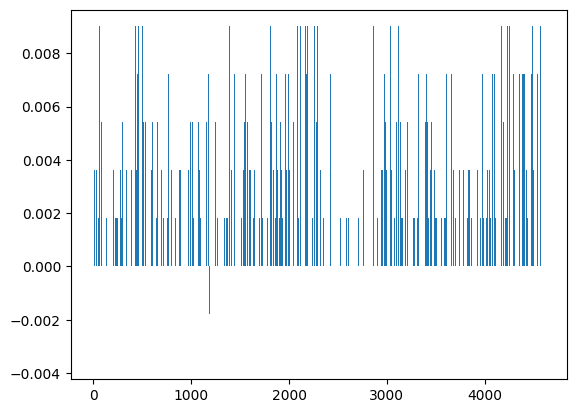

In [35]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calculate permutation importance
results = permutation_importance(best_svm_final, X_test, y_test, scoring='accuracy')

# get importance
importance = results.importances_mean

# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance for all embeddings (for reference only)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

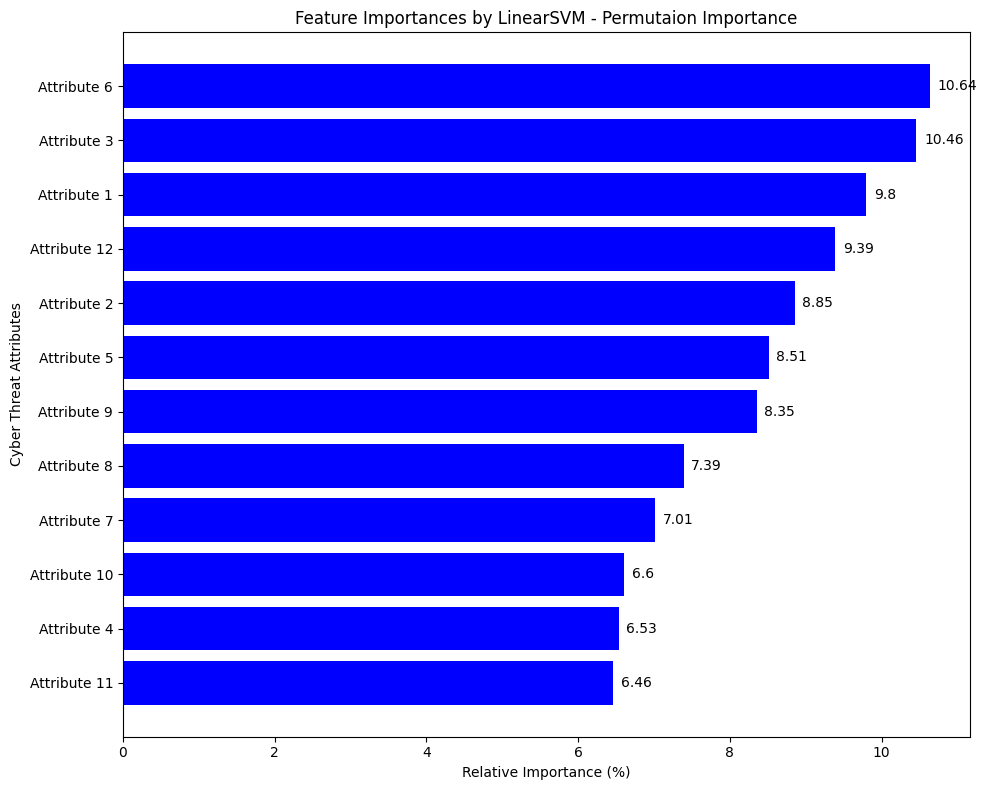

In [38]:
import matplotlib.pyplot as plt

# Sum up feature importance for all threat attributes
feature_importance_main =  np.array([np.sum(importance[main*emb_dim:(main+1)*emb_dim]) for main in range(nfeature)])

# Normalize the importances so they sum to 1 (or 100%)
feature_importances_percentage = (feature_importance_main / feature_importance_main.sum()) * 100

# Sort the importances in descending order
sorted_indices = np.argsort(feature_importances_percentage)
sorted_importances = feature_importances_percentage[sorted_indices]

# Corresponding main feature labels (1 to 12)
features = [f"Attribute {i}" for i in range(1, nfeature+1)]
sorted_features = [features[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_features, sorted_importances, color='blue')

# Add values next to the bars
for bar in bars:
    xval = bar.get_width()  # Get the width of the bar (its length)
    plt.text(xval + 0.1, bar.get_y() + bar.get_height()/2, round(xval, 2), 
             ha='left', va='center')  # Adjust horizontal position after the bar

plt.ylabel("Cyber Threat Attributes")
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importances by LinearSVM - Permutaion Importance")
plt.tight_layout()

# Save the plot
plt.savefig('Feature Importances by LinearSVM - Permutaion Importance.png', dpi=300, bbox_inches='tight')

plt.show()

## Feature Importance with Built-in method (SVM)

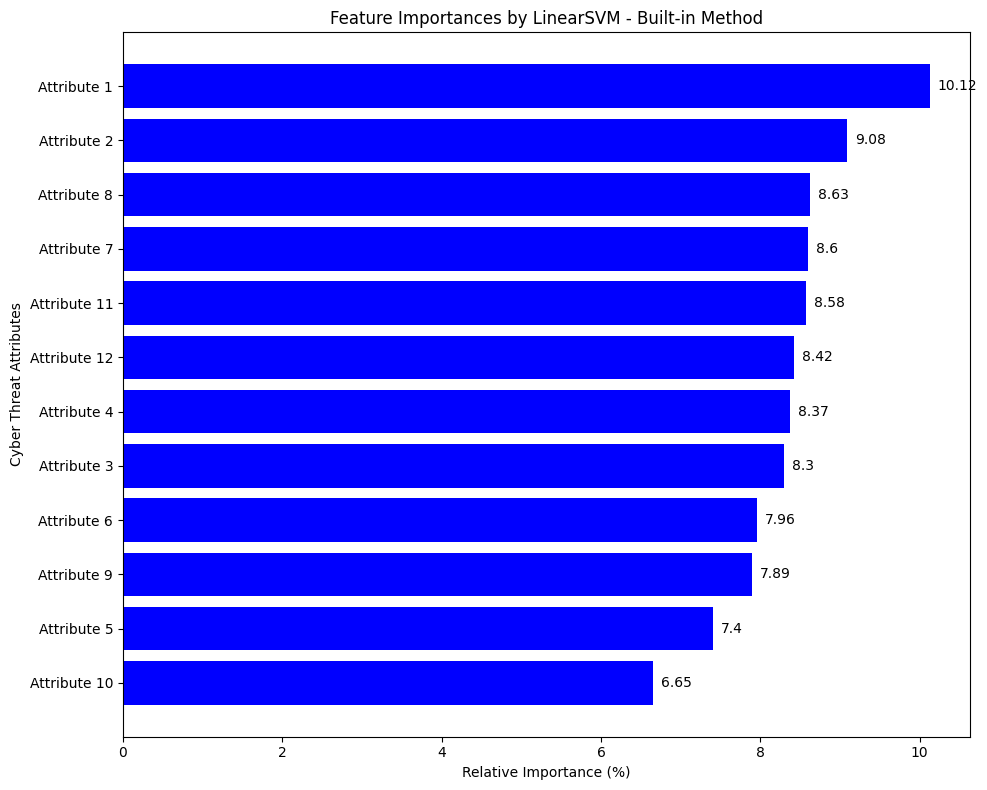

In [37]:
import matplotlib.pyplot as plt

# Get coefficients
coefficients = best_svm_final.coef_

# Calculate the average magnitude of coefficients for each feature
average_importance = np.mean(np.abs(coefficients), axis=0)

# Sum the feature importance for all threat attributes
feature_importance_main =  np.array([np.sum(average_importance[main*emb_dim:(main+1)*emb_dim]) for main in range(nfeature)])

# Normalize the importances so they sum to 1 (or 100%)
feature_importances_percentage = (feature_importance_main / feature_importance_main.sum()) * 100

# Sort the importances in descending order
sorted_indices = np.argsort(feature_importances_percentage)
sorted_importances = feature_importances_percentage[sorted_indices]

# Corresponding main feature labels (1 to 12)
features = [f"Attribute {i}" for i in range(1, nfeature+1)]
sorted_features = [features[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_features, sorted_importances, color='blue')

# Add values next to the bars
for bar in bars:
    xval = bar.get_width()  # Get the width of the bar (its length)
    plt.text(xval + 0.1, bar.get_y() + bar.get_height()/2, round(xval, 2), 
             ha='left', va='center')  # Adjust horizontal position after the bar

plt.ylabel("Cyber Threat Attributes")
plt.xlabel("Relative Importance (%)")
plt.title("Feature Importances by LinearSVM - Built-in Method")
plt.tight_layout()

# Save the plot
plt.savefig('Feature Importances by LinearSVM - Built-in Method.png', dpi=300, bbox_inches='tight')

plt.show()